In [ ]:
# --- Imports ---
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import numpy as np
import random
import time
import os
from tensorflow.keras.datasets import mnist
from PIL import Image
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd

# --- Settings ---
NUM_CLIENTS = 50  # Increased number of clients
NUM_ROUNDS = 20  # More rounds for stability
INITIAL_LOCAL_EPOCHS = 5
LATER_LOCAL_EPOCHS = 10
BATCH_SIZE = 64  # Slightly bigger batch
LEARNING_RATE = 0.001
SAVE_EVERY = 5
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
ROTATION_ANGLES = [0, 15, 30]  # Easier rotations

# --- Load MNIST Dataset ---
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

# --- Model: Improved CNN ---
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.net = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1), nn.BatchNorm2d(32), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1), nn.BatchNorm2d(64), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(64, 128, 3, padding=1), nn.BatchNorm2d(128), nn.ReLU(), nn.AdaptiveAvgPool2d(1),
            nn.Flatten(), nn.Linear(128, 10)
        )
    def forward(self, x):
        return self.net(x)

# --- Dataset: Rotated MNIST ---
class RotatedMNIST(Dataset):
    def __init__(self, images, labels, angle):
        self.images = images
        self.labels = labels
        self.angle = angle
        self.transform = transforms.Compose([
            transforms.Lambda(lambda img: transforms.functional.rotate(img, self.angle)),
            transforms.RandomAffine(degrees=5, translate=(0.05, 0.05)),
            transforms.ToTensor()
        ])
    def __len__(self):
        return len(self.images)
    def __getitem__(self, idx):
        img = Image.fromarray((self.images[idx] * 255).astype(np.uint8))
        img = self.transform(img)
        label = int(self.labels[idx])
        return img, label

# --- Helper: Flatten Model Weights ---
def flatten_weights(state_dict):
    return torch.cat([w.flatten() for w in state_dict.values()]).cpu().numpy()

# --- Check for NaN Values ---
def check_for_nans(weights, name="weights"):
    if np.any(np.isnan(weights)):
        print(f"NaN values found in {name}!")
        return True
    return False

# --- Local Training with FedProx ---
def train_local(model, dataset, epochs, mu=0.01):
    local_model = CNN().to(DEVICE)
    local_model.load_state_dict(model.state_dict())
    local_model.train()
    loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)
    optimizer = optim.Adam(local_model.parameters(), lr=LEARNING_RATE)
    loss_fn = nn.CrossEntropyLoss()
    global_params = {k: v.detach().clone() for k, v in model.state_dict().items()}

    for epoch in range(epochs):
        for x, y in loader:
            x, y = x.to(DEVICE), y.to(DEVICE)
            optimizer.zero_grad()
            preds = local_model(x)
            loss = loss_fn(preds, y)

            # FedProx regularization
            prox_reg = sum(((param - global_params[name]) ** 2).sum() for name, param in local_model.named_parameters())
            loss += (mu / 2) * prox_reg

            loss.backward()
            optimizer.step()
    return local_model.state_dict()

# --- Evaluation ---
@torch.no_grad()
def evaluate(model, images, labels, angle=0):
    model.eval()
    dataset = RotatedMNIST(images, labels, angle)
    loader = DataLoader(dataset, batch_size=128)
    correct, total = 0, 0
    for x, y in loader:
        x, y = x.to(DEVICE), y.to(DEVICE)
        out = model(x)
        pred = out.argmax(dim=1)
        correct += (pred == y).sum().item()
        total += y.size(0)
    return correct / total

# --- Trust Index Calculation ---
def compute_trust_index(local_weights, global_weights, accuracies, alpha=0.3, beta=0.6, gamma=0.1):
    similarities = [cosine_similarity([w], [global_weights])[0][0] for w in local_weights]
    reliabilities = similarities
    trust_raw = alpha * np.array(similarities) + beta * np.array(accuracies) + gamma * np.array(reliabilities)
    trust_raw = np.maximum(trust_raw, 1e-5)  # Avoid 0
    return trust_raw / trust_raw.sum(), similarities

# --- Federated Aggregation ---
def federated_aggregation(local_states, trust_index, cluster_weights):
    aggregated = {}
    keys = local_states[0].keys()
    total_weight = np.sum(trust_index * cluster_weights)
    for key in keys:
        layer_sum = sum(local_states[i][key] * trust_index[i] * cluster_weights[i] for i in range(len(local_states)))
        aggregated[key] = layer_sum / total_weight
    return aggregated

# --- Initialize ---
global_model = CNN().to(DEVICE)
client_indices = np.array_split(np.arange(len(x_train)), NUM_CLIENTS)
client_datasets = [(x_train[idx], y_train[idx]) for idx in client_indices]

# --- Logs ---
logs = []

# --- Federated Learning Loop ---
for round in range(NUM_ROUNDS):
    print(f"\n--- Round {round} ---")
    start = time.time()

    local_states = []
    local_vectors = []
    local_accuracies = []

    LOCAL_EPOCHS = INITIAL_LOCAL_EPOCHS if round < 10 else LATER_LOCAL_EPOCHS

    # Local training
    for client_id in range(NUM_CLIENTS):
        rotation = random.choice(ROTATION_ANGLES)
        dataset = RotatedMNIST(*client_datasets[client_id], rotation)
        updated_state = train_local(global_model, dataset, LOCAL_EPOCHS)

        local_vector = flatten_weights(updated_state)
        if check_for_nans(local_vector, name=f"local_vectors[{client_id}]"):
            continue

        model_temp = CNN().to(DEVICE)
        model_temp.load_state_dict(updated_state)
        acc = evaluate(model_temp, x_test, y_test)

        local_states.append(updated_state)
        local_vectors.append(local_vector)
        local_accuracies.append(acc)

    # Trust index
    global_vector = flatten_weights(global_model.state_dict())
    if check_for_nans(global_vector, name="global_vector"):
        continue

    trust_index, similarities = compute_trust_index(local_vectors, global_vector, local_accuracies)

    # Clustering (only after 5 rounds)
    if round >= 5:
        scores = []
        max_k = min(NUM_CLIENTS - 1, 10)
        K_range = range(2, max_k + 1)

        for k in K_range:
            kmeans = KMeans(n_clusters=k, random_state=42).fit(local_vectors)
            labels = kmeans.labels_
            if len(np.unique(labels)) > 1:
                score = silhouette_score(local_vectors, labels)
                scores.append(score)
            else:
                scores.append(-1)

        optimal_k = K_range[np.argmax(scores)]
        print(f"Optimal number of clusters: {optimal_k}")

        kmeans = KMeans(n_clusters=optimal_k, random_state=42).fit(local_vectors)
        cluster_labels = kmeans.labels_

        # Cluster contributions
        cluster_contributions = np.zeros(optimal_k)
        for i in range(optimal_k):
            members = np.where(cluster_labels == i)[0]
            if len(members) > 1:
                intra_sim = np.mean([
                    cosine_similarity([local_vectors[m1]], [local_vectors[m2]])[0][0]
                    for m1 in members for m2 in members if m1 != m2
                ])
                cluster_contributions[i] = (len(members) + intra_sim) / 2
            else:
                cluster_contributions[i] = 1.0  # singleton cluster

        cluster_weights = cluster_contributions / np.sum(cluster_contributions)
        client_cluster_weights = np.array([cluster_weights[c] for c in cluster_labels])
    else:
        client_cluster_weights = np.ones(len(local_states))

    # Aggregation
    aggregated_state = federated_aggregation(local_states, trust_index, client_cluster_weights)

    # Update global model
    global_model.load_state_dict(aggregated_state)

    # Evaluation
    acc = evaluate(global_model, x_test, y_test)
    round_time = time.time() - start
    print(f"Accuracy: {acc*100:.2f}% | Time: {round_time:.2f}s")

    # Log
    logs.append({
        "round": round,
        "accuracy": acc,
        "time": round_time,
        "trust_index": trust_index.tolist(),
        "client_weights": client_cluster_weights.tolist()
    })

    if round % SAVE_EVERY == 0:
        torch.save(global_model.state_dict(), f"global_model_round_{round}.pt")

print("\nTraining complete!")

# --- Final Results ---
accuracies = [log['accuracy'] * 100 for log in logs]
mean_acc = np.mean(accuracies)
std_acc = np.std(accuracies)

results_table = pd.DataFrame({
    'Method': ['OurModel_Improved'],
    'Accuracy (%) ± std': [f"{mean_acc:.2f} ± {std_acc:.2f}"]
})

print(results_table)



--- Round 0 ---


KeyboardInterrupt: 

This is main without dp noise for  getting results


In [ ]:
# --- Imports ---
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import numpy as np
import random
import time
import os
from tensorflow.keras.datasets import mnist
from PIL import Image
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- Settings ---
NUM_CLIENTS = 50
NUM_ROUNDS = 20
INITIAL_LOCAL_EPOCHS = 5
LATER_LOCAL_EPOCHS = 10
BATCH_SIZE = 64
LEARNING_RATE = 0.001
SAVE_EVERY = 5
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
ROTATION_ANGLES = [0, 15, 30]

# --- Load MNIST Dataset ---
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step



--- Round 0 ---
Accuracy: 71.39% | Time: 204.31s

--- Round 1 ---
Accuracy: 87.45% | Time: 198.81s

--- Round 2 ---
Accuracy: 93.87% | Time: 196.54s

--- Round 3 ---
Accuracy: 92.86% | Time: 197.83s

--- Round 4 ---
Accuracy: 93.68% | Time: 200.47s

--- Round 5 ---
Optimal number of clusters: 2
Accuracy: 94.49% | Time: 200.46s

--- Round 6 ---
Optimal number of clusters: 2
Accuracy: 94.69% | Time: 200.48s

--- Round 7 ---
Optimal number of clusters: 2
Accuracy: 95.33% | Time: 200.34s

--- Round 8 ---
Optimal number of clusters: 2
Accuracy: 96.11% | Time: 200.13s

--- Round 9 ---
Optimal number of clusters: 2
Accuracy: 95.84% | Time: 199.69s

--- Round 10 ---
Optimal number of clusters: 2
Accuracy: 94.26% | Time: 288.81s

--- Round 11 ---
Optimal number of clusters: 2
Accuracy: 95.54% | Time: 288.26s

--- Round 12 ---
Optimal number of clusters: 2
Accuracy: 96.77% | Time: 288.28s

--- Round 13 ---
Optimal number of clusters: 2
Accuracy: 96.20% | Time: 287.94s

--- Round 14 ---
Optimal 

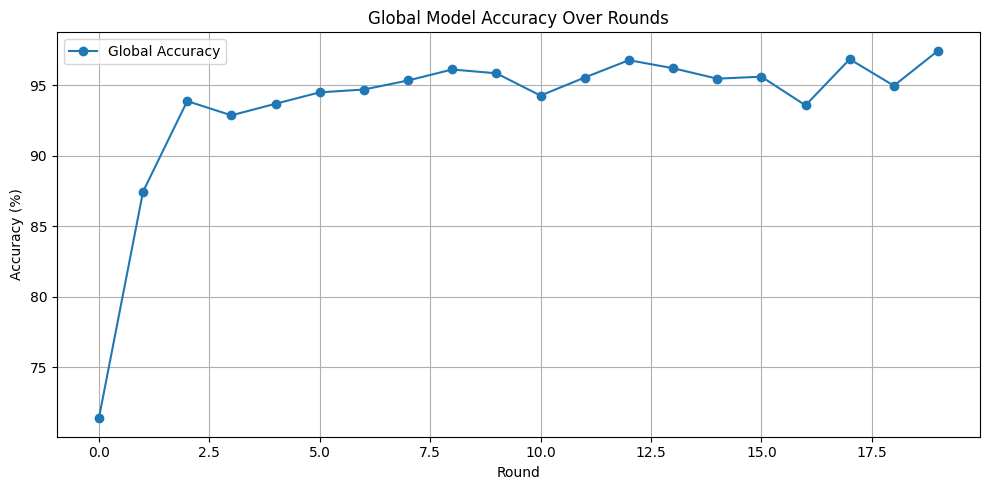

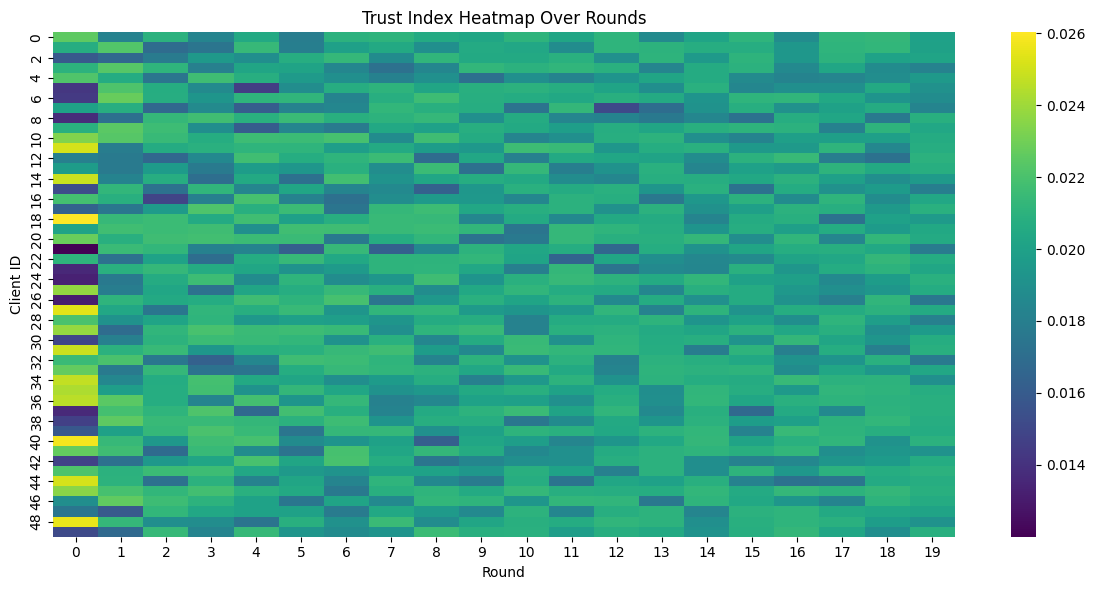

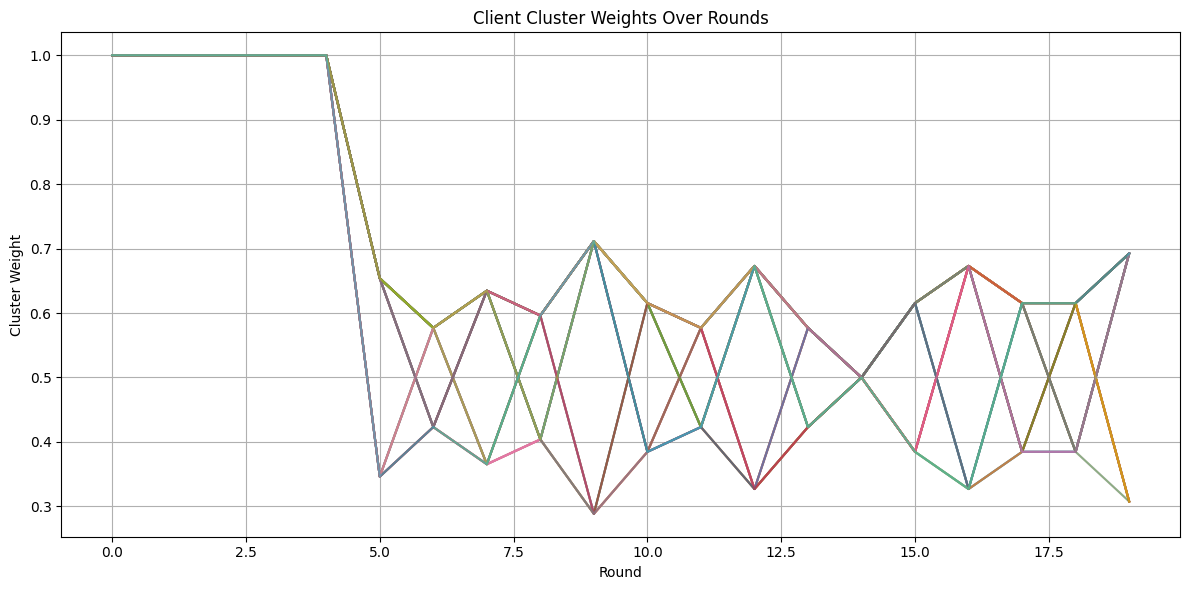

In [ ]:

# --- Model: Improved CNN ---
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.net = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1), nn.BatchNorm2d(32), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1), nn.BatchNorm2d(64), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(64, 128, 3, padding=1), nn.BatchNorm2d(128), nn.ReLU(), nn.AdaptiveAvgPool2d(1),
            nn.Flatten(), nn.Linear(128, 10)
        )
    def forward(self, x):
        return self.net(x)

# --- Dataset: Rotated MNIST ---
class RotatedMNIST(Dataset):
    def __init__(self, images, labels, angle):
        self.images = images
        self.labels = labels
        self.angle = angle
        self.transform = transforms.Compose([
            transforms.Lambda(lambda img: transforms.functional.rotate(img, self.angle)),
            transforms.RandomAffine(degrees=5, translate=(0.05, 0.05)),
            transforms.ToTensor()
        ])
    def __len__(self):
        return len(self.images)
    def __getitem__(self, idx):
        img = Image.fromarray((self.images[idx] * 255).astype(np.uint8))
        img = self.transform(img)
        label = int(self.labels[idx])
        return img, label

# --- Helper Functions ---
def flatten_weights(state_dict):
    return torch.cat([w.flatten() for w in state_dict.values()]).cpu().numpy()

def check_for_nans(weights, name="weights"):
    if np.any(np.isnan(weights)):
        print(f"NaN values found in {name}!")
        return True
    return False

def train_local(model, dataset, epochs, mu=0.01):
    local_model = CNN().to(DEVICE)
    local_model.load_state_dict(model.state_dict())
    local_model.train()
    loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)
    optimizer = optim.Adam(local_model.parameters(), lr=LEARNING_RATE)
    loss_fn = nn.CrossEntropyLoss()
    global_params = {k: v.detach().clone() for k, v in model.state_dict().items()}

    for epoch in range(epochs):
        for x, y in loader:
            x, y = x.to(DEVICE), y.to(DEVICE)
            optimizer.zero_grad()
            preds = local_model(x)
            loss = loss_fn(preds, y)
            prox_reg = sum(((param - global_params[name]) ** 2).sum() for name, param in local_model.named_parameters())
            loss += (mu / 2) * prox_reg
            loss.backward()
            optimizer.step()
    return local_model.state_dict()

@torch.no_grad()
def evaluate(model, images, labels, angle=0):
    model.eval()
    dataset = RotatedMNIST(images, labels, angle)
    loader = DataLoader(dataset, batch_size=128)
    correct, total = 0, 0
    for x, y in loader:
        x, y = x.to(DEVICE), y.to(DEVICE)
        out = model(x)
        pred = out.argmax(dim=1)
        correct += (pred == y).sum().item()
        total += y.size(0)
    return correct / total

def compute_trust_index(local_weights, global_weights, accuracies, alpha=0.3, beta=0.6, gamma=0.1):
    similarities = [cosine_similarity([w], [global_weights])[0][0] for w in local_weights]
    reliabilities = similarities
    trust_raw = alpha * np.array(similarities) + beta * np.array(accuracies) + gamma * np.array(reliabilities)
    trust_raw = np.maximum(trust_raw, 1e-5)
    return trust_raw / trust_raw.sum(), similarities

def federated_aggregation(local_states, trust_index, cluster_weights):
    aggregated = {}
    keys = local_states[0].keys()
    total_weight = np.sum(trust_index * cluster_weights)
    for key in keys:
        layer_sum = sum(local_states[i][key] * trust_index[i] * cluster_weights[i] for i in range(len(local_states)))
        aggregated[key] = layer_sum / total_weight
    return aggregated

# --- Initialize ---
global_model = CNN().to(DEVICE)
client_indices = np.array_split(np.arange(len(x_train)), NUM_CLIENTS)
client_datasets = [(x_train[idx], y_train[idx]) for idx in client_indices]
logs = []

# --- Federated Learning Loop ---
for round in range(NUM_ROUNDS):
    print(f"\n--- Round {round} ---")
    start = time.time()
    local_states, local_vectors, local_accuracies = [], [], []
    LOCAL_EPOCHS = INITIAL_LOCAL_EPOCHS if round < 10 else LATER_LOCAL_EPOCHS

    for client_id in range(NUM_CLIENTS):
        rotation = random.choice(ROTATION_ANGLES)
        dataset = RotatedMNIST(*client_datasets[client_id], rotation)
        updated_state = train_local(global_model, dataset, LOCAL_EPOCHS)
        local_vector = flatten_weights(updated_state)
        if check_for_nans(local_vector, name=f"local_vectors[{client_id}]"):
            continue
        model_temp = CNN().to(DEVICE)
        model_temp.load_state_dict(updated_state)
        acc = evaluate(model_temp, x_test, y_test)
        local_states.append(updated_state)
        local_vectors.append(local_vector)
        local_accuracies.append(acc)

    global_vector = flatten_weights(global_model.state_dict())
    if check_for_nans(global_vector, name="global_vector"):
        continue
    trust_index, similarities = compute_trust_index(local_vectors, global_vector, local_accuracies)

    if round >= 5:
        scores = []
        max_k = min(NUM_CLIENTS - 1, 10)
        K_range = range(2, max_k + 1)
        for k in K_range:
            kmeans = KMeans(n_clusters=k, random_state=42).fit(local_vectors)
            labels = kmeans.labels_
            score = silhouette_score(local_vectors, labels) if len(np.unique(labels)) > 1 else -1
            scores.append(score)
        optimal_k = K_range[np.argmax(scores)]
        print(f"Optimal number of clusters: {optimal_k}")
        kmeans = KMeans(n_clusters=optimal_k, random_state=42).fit(local_vectors)
        cluster_labels = kmeans.labels_
        cluster_contributions = np.zeros(optimal_k)
        for i in range(optimal_k):
            members = np.where(cluster_labels == i)[0]
            if len(members) > 1:
                intra_sim = np.mean([cosine_similarity([local_vectors[m1]], [local_vectors[m2]])[0][0] for m1 in members for m2 in members if m1 != m2])
                cluster_contributions[i] = (len(members) + intra_sim) / 2
            else:
                cluster_contributions[i] = 1.0
        cluster_weights = cluster_contributions / np.sum(cluster_contributions)
        client_cluster_weights = np.array([cluster_weights[c] for c in cluster_labels])
    else:
        client_cluster_weights = np.ones(len(local_states))

    aggregated_state = federated_aggregation(local_states, trust_index, client_cluster_weights)
    global_model.load_state_dict(aggregated_state)
    acc = evaluate(global_model, x_test, y_test)
    round_time = time.time() - start
    print(f"Accuracy: {acc*100:.2f}% | Time: {round_time:.2f}s")

    logs.append({
        "round": round,
        "accuracy": acc,
        "time": round_time,
        "trust_index": trust_index.tolist(),
        "client_weights": client_cluster_weights.tolist()
    })
    if round % SAVE_EVERY == 0:
        torch.save(global_model.state_dict(), f"global_model_round_{round}.pt")

# --- Final Results ---
accuracies = [log['accuracy'] * 100 for log in logs]
mean_acc = np.mean(accuracies)
std_acc = np.std(accuracies)
results_table = pd.DataFrame({
    'Method': ['OurModel_Improved'],
    'Accuracy (%) ± std': [f"{mean_acc:.2f} ± {std_acc:.2f}"]
})
results_table.to_csv("results_table.csv", index=False)
print(results_table)

# --- Plotting ---
plt.figure(figsize=(10, 5))
plt.plot(accuracies, label='Global Accuracy', marker='o')
plt.xlabel("Round")
plt.ylabel("Accuracy (%)")
plt.title("Global Model Accuracy Over Rounds")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig("global_accuracy.png")
plt.show()

plt.figure(figsize=(12, 6))
trust_matrix = np.array([log['trust_index'] for log in logs])
sns.heatmap(trust_matrix.T, cmap="viridis", cbar=True)
plt.xlabel("Round")
plt.ylabel("Client ID")
plt.title("Trust Index Heatmap Over Rounds")
plt.tight_layout()
plt.savefig("trust_index_heatmap.png")
plt.show()

plt.figure(figsize=(12, 6))
cluster_weights_log = [log.get('client_weights', []) for log in logs]
for client_id in range(NUM_CLIENTS):
    weights = [round_weights[client_id] if client_id < len(round_weights) else 0 for round_weights in cluster_weights_log]
    plt.plot(weights, alpha=0.5, label=f"Client {client_id}" if client_id < 5 else "")
plt.xlabel("Round")
plt.ylabel("Cluster Weight")
plt.title("Client Cluster Weights Over Rounds")
plt.grid(True)
plt.tight_layout()
plt.savefig("client_cluster_weights.png")
plt.show()

              precision    recall  f1-score     support
0              0.964250  0.990816  0.977353    980.0000
1              0.972390  0.992952  0.982563   1135.0000
2              0.977626  0.973837  0.975728   1032.0000
3              0.989152  0.993069  0.991107   1010.0000
4              0.995763  0.957230  0.976116    982.0000
5              0.974359  0.979821  0.977082    892.0000
6              0.984326  0.983299  0.983812    958.0000
7              0.982213  0.966926  0.974510   1028.0000
8              0.966667  0.982546  0.974542    974.0000
9              0.972782  0.956392  0.964518   1009.0000
accuracy       0.977800  0.977800  0.977800      0.9778
macro avg      0.977953  0.977689  0.977733  10000.0000
weighted avg   0.977932  0.977800  0.977778  10000.0000


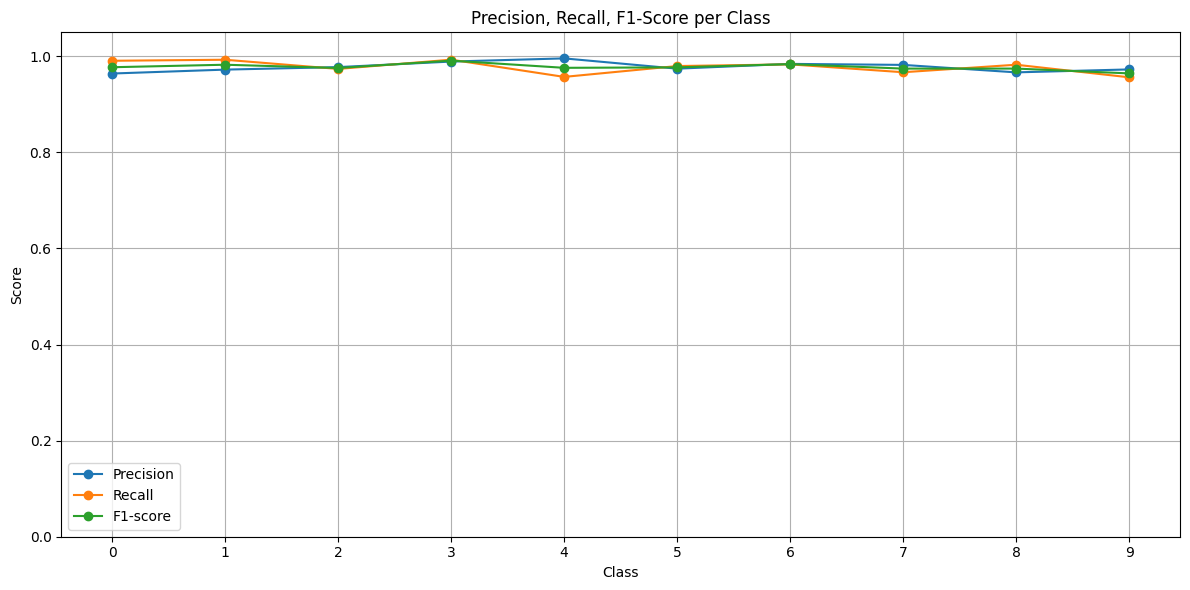

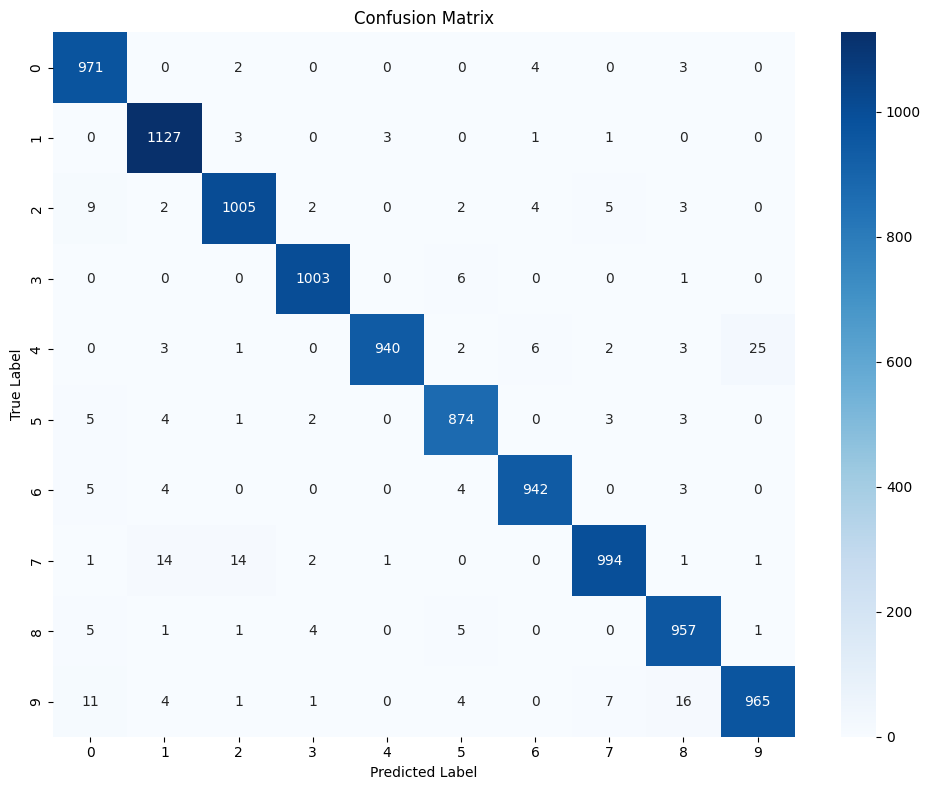

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
@torch.no_grad()
def evaluate_metrics(model, images, labels, angle=0):
    model.eval()
    dataset = RotatedMNIST(images, labels, angle)
    loader = DataLoader(dataset, batch_size=128)

    all_preds = []
    all_labels = []

    for x, y in loader:
        x, y = x.to(DEVICE), y.to(DEVICE)
        out = model(x)
        pred = out.argmax(dim=1).cpu().numpy()
        all_preds.extend(pred)
        all_labels.extend(y.cpu().numpy())

    return np.array(all_labels), np.array(all_preds)

# Get true and predicted labels
y_true, y_pred = evaluate_metrics(global_model, x_test, y_test)

# Classification Report
report = classification_report(y_true, y_pred, output_dict=True)
df_report = pd.DataFrame(report).transpose()
df_report.to_csv("classification_report.csv")
print(df_report)

# Plot: Precision, Recall, F1-Score
metrics = ['precision', 'recall', 'f1-score']
classes = [str(i) for i in range(10)]

plt.figure(figsize=(12, 6))
for metric in metrics:
    plt.plot(classes, [report[c][metric] for c in classes], marker='o', label=metric.capitalize())
plt.title("Precision, Recall, F1-Score per Class")
plt.xlabel("Class")
plt.ylabel("Score")
plt.ylim(0, 1.05)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("precision_recall_f1_per_class.png")
plt.show()

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.savefig("confusion_matrix.png")
plt.show()
